In [1]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

class CIFAR10InMemoryDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Preload data into memory
def load_cifar10_in_memory(data_dir):
    images, labels = [], []
    for i in range(1, 6):
        with open(f"{data_dir}/data_batch_{i}", 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            images.append(batch[b'data'])
            labels.extend(batch[b'labels'])
    images = np.vstack(images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape and reorder dimensions
    labels = np.array(labels)

    # Load test data
    with open(f"{data_dir}/test_batch", 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        test_images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        test_labels = np.array(batch[b'labels'])
        
    return images, labels, test_images, test_labels

# Load CIFAR-10 data into memory
data_dir = "/kaggle/input/cifar-data/cifar-10-batches-py"
train_images, train_labels, test_images, test_labels = load_cifar10_in_memory(data_dir)

# Define simple transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Create in-memory datasets
train_dataset = CIFAR10InMemoryDataset(train_images, train_labels, transform=train_transforms)
test_dataset = CIFAR10InMemoryDataset(test_images, test_labels, transform=test_transforms)

# Create DataLoaders with fewer workers
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=0)


### Pre-Trained ResNet Model

In [2]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained ResNet model (e.g., ResNet18)
resnet_model = models.resnet18(pretrained=True)
resnet_model = resnet_model.to(device)

# Freeze the pretrained layers
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for CIFAR-10 (10 classes)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 10)  # 10 output classes for CIFAR-10
resnet_model.fc = resnet_model.fc.to(device)

# Define loss and optimizer (only train the final classifier layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)  # Only train the final layer

# Training and validation loop
n_epochs = 30  # Specify the number of epochs
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Training phase
    resnet_model.train()
    total_train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{n_epochs}] Training"):
        images, labels = images.to(device), labels.to(device).long()  # Ensure labels are of type torch.long

        # Forward pass
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation phase (using test_loader)
    resnet_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:  # Use test_loader instead of val_loader
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{n_epochs}], Validation Loss (Test Set): {avg_val_loss:.4f}")



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.8MB/s]
Epoch [1/30] Training: 100%|██████████| 98/98 [01:13<00:00,  1.34it/s]


Epoch [1/30], Training Loss: 2.0275
Epoch [1/30], Validation Loss (Test Set): 1.8029


Epoch [2/30] Training: 100%|██████████| 98/98 [01:12<00:00,  1.36it/s]


Epoch [2/30], Training Loss: 1.8081
Epoch [2/30], Validation Loss (Test Set): 1.7357


Epoch [3/30] Training: 100%|██████████| 98/98 [01:11<00:00,  1.37it/s]


Epoch [3/30], Training Loss: 1.7622
Epoch [3/30], Validation Loss (Test Set): 1.7226


Epoch [4/30] Training: 100%|██████████| 98/98 [01:10<00:00,  1.38it/s]


Epoch [4/30], Training Loss: 1.7507
Epoch [4/30], Validation Loss (Test Set): 1.7064


Epoch [5/30] Training: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Epoch [5/30], Training Loss: 1.7435
Epoch [5/30], Validation Loss (Test Set): 1.7020


Epoch [6/30] Training: 100%|██████████| 98/98 [01:12<00:00,  1.36it/s]


Epoch [6/30], Training Loss: 1.7309
Epoch [6/30], Validation Loss (Test Set): 1.7059


Epoch [7/30] Training: 100%|██████████| 98/98 [01:10<00:00,  1.39it/s]


Epoch [7/30], Training Loss: 1.7260
Epoch [7/30], Validation Loss (Test Set): 1.6861


Epoch [8/30] Training: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Epoch [8/30], Training Loss: 1.7188
Epoch [8/30], Validation Loss (Test Set): 1.6831


Epoch [9/30] Training: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Epoch [9/30], Training Loss: 1.7086
Epoch [9/30], Validation Loss (Test Set): 1.6784


Epoch [10/30] Training: 100%|██████████| 98/98 [01:17<00:00,  1.27it/s]


Epoch [10/30], Training Loss: 1.7151
Epoch [10/30], Validation Loss (Test Set): 1.6930


Epoch [11/30] Training: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Epoch [11/30], Training Loss: 1.7139
Epoch [11/30], Validation Loss (Test Set): 1.6976


Epoch [12/30] Training: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s]


Epoch [12/30], Training Loss: 1.7158
Epoch [12/30], Validation Loss (Test Set): 1.6842


Epoch [13/30] Training: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Epoch [13/30], Training Loss: 1.7170
Epoch [13/30], Validation Loss (Test Set): 1.6836


Epoch [14/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Epoch [14/30], Training Loss: 1.7101
Epoch [14/30], Validation Loss (Test Set): 1.6824


Epoch [15/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Epoch [15/30], Training Loss: 1.7152
Epoch [15/30], Validation Loss (Test Set): 1.6801


Epoch [16/30] Training: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [16/30], Training Loss: 1.7042
Epoch [16/30], Validation Loss (Test Set): 1.6809


Epoch [17/30] Training: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Epoch [17/30], Training Loss: 1.7096
Epoch [17/30], Validation Loss (Test Set): 1.6856


Epoch [18/30] Training: 100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


Epoch [18/30], Training Loss: 1.7096
Epoch [18/30], Validation Loss (Test Set): 1.6800


Epoch [19/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Epoch [19/30], Training Loss: 1.7135
Epoch [19/30], Validation Loss (Test Set): 1.6826


Epoch [20/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Epoch [20/30], Training Loss: 1.7022
Epoch [20/30], Validation Loss (Test Set): 1.6805


Epoch [21/30] Training: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch [21/30], Training Loss: 1.7132
Epoch [21/30], Validation Loss (Test Set): 1.6795


Epoch [22/30] Training: 100%|██████████| 98/98 [01:26<00:00,  1.14it/s]


Epoch [22/30], Training Loss: 1.7092
Epoch [22/30], Validation Loss (Test Set): 1.6840


Epoch [23/30] Training: 100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Epoch [23/30], Training Loss: 1.7147
Epoch [23/30], Validation Loss (Test Set): 1.6805


Epoch [24/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Epoch [24/30], Training Loss: 1.7091
Epoch [24/30], Validation Loss (Test Set): 1.6847


Epoch [25/30] Training: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch [25/30], Training Loss: 1.7080
Epoch [25/30], Validation Loss (Test Set): 1.6837


Epoch [26/30] Training: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch [26/30], Training Loss: 1.7079
Epoch [26/30], Validation Loss (Test Set): 1.6801


Epoch [27/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Epoch [27/30], Training Loss: 1.7064
Epoch [27/30], Validation Loss (Test Set): 1.6836


Epoch [28/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Epoch [28/30], Training Loss: 1.7067
Epoch [28/30], Validation Loss (Test Set): 1.6782


Epoch [29/30] Training: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Epoch [29/30], Training Loss: 1.7071
Epoch [29/30], Validation Loss (Test Set): 1.6910


Epoch [30/30] Training: 100%|██████████| 98/98 [01:24<00:00,  1.17it/s]


Epoch [30/30], Training Loss: 1.7086
Epoch [30/30], Validation Loss (Test Set): 1.6862


In [3]:
# Save the entire model after training
torch.save(resnet_model, 'resnet18_PRETRAIN_full_model.pth')
print("Entire model saved as 'resnet18_cifar10_full_model.pth'")


Entire model saved as 'resnet18_cifar10_full_model.pth'


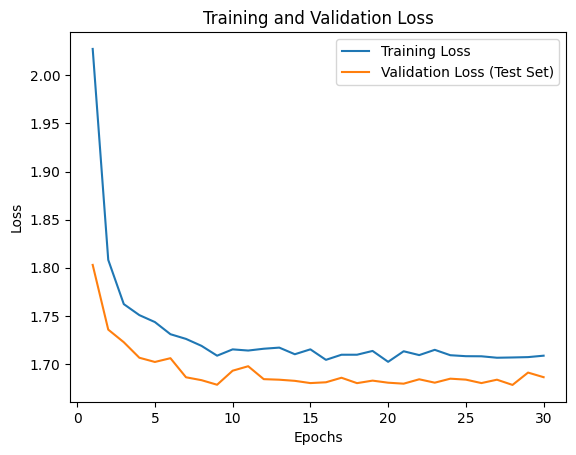

In [4]:
# Plotting training and validation loss
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss (Test Set)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Implementing ResNet-18 from Scratch

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # Used for adjusting the input shape to match the output when necessary

    def forward(self, x):
        identity = x  # Save the input for the shortcut path
        if self.downsample is not None:
            identity = self.downsample(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add the shortcut (identity) to the output of the convolutions
        out += identity
        out = F.relu(out)
        return out


In [6]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        
        # Initial convolution and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks with 2, 2, 2, 2 layers
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution and max pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        # Forward pass through each layer of residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x


In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 30
learning_rate = 0.001

# Instantiate the model, loss function, and optimizer
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training"):
        images, labels = images.to(device), labels.to(device).long()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Calculate validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")



# Evaluation on the test set for accuracy, precision, recall, and F1 score
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_preds) * 100
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Epoch [1/30] Training: 100%|██████████| 98/98 [01:28<00:00,  1.10it/s]


Epoch [1/30], Training Loss: 1.6663
Epoch [1/30], Validation Loss: 1.2926


Epoch [2/30] Training: 100%|██████████| 98/98 [01:30<00:00,  1.08it/s]


Epoch [2/30], Training Loss: 1.2801
Epoch [2/30], Validation Loss: 1.1064


Epoch [3/30] Training: 100%|██████████| 98/98 [01:30<00:00,  1.08it/s]


Epoch [3/30], Training Loss: 1.1028
Epoch [3/30], Validation Loss: 0.9658


Epoch [4/30] Training: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch [4/30], Training Loss: 0.9852
Epoch [4/30], Validation Loss: 0.9928


Epoch [5/30] Training: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch [5/30], Training Loss: 0.9169
Epoch [5/30], Validation Loss: 0.9007


Epoch [6/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Epoch [6/30], Training Loss: 0.8526
Epoch [6/30], Validation Loss: 0.8129


Epoch [7/30] Training: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [7/30], Training Loss: 0.7968
Epoch [7/30], Validation Loss: 0.7752


Epoch [8/30] Training: 100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Epoch [8/30], Training Loss: 0.7602
Epoch [8/30], Validation Loss: 0.7409


Epoch [9/30] Training: 100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Epoch [9/30], Training Loss: 0.7240
Epoch [9/30], Validation Loss: 0.7101


Epoch [10/30] Training: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [10/30], Training Loss: 0.6960
Epoch [10/30], Validation Loss: 0.7139


Epoch [11/30] Training: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Epoch [11/30], Training Loss: 0.6653
Epoch [11/30], Validation Loss: 0.7078


Epoch [12/30] Training: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [12/30], Training Loss: 0.6430
Epoch [12/30], Validation Loss: 0.7657


Epoch [13/30] Training: 100%|██████████| 98/98 [01:21<00:00,  1.20it/s]


Epoch [13/30], Training Loss: 0.6184
Epoch [13/30], Validation Loss: 0.7314


Epoch [14/30] Training: 100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Epoch [14/30], Training Loss: 0.5955
Epoch [14/30], Validation Loss: 0.6866


Epoch [15/30] Training: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s]


Epoch [15/30], Training Loss: 0.5794
Epoch [15/30], Validation Loss: 0.6383


Epoch [16/30] Training: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [16/30], Training Loss: 0.5645
Epoch [16/30], Validation Loss: 0.6664


Epoch [17/30] Training: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Epoch [17/30], Training Loss: 0.5452
Epoch [17/30], Validation Loss: 0.6072


Epoch [18/30] Training: 100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


Epoch [18/30], Training Loss: 0.5295
Epoch [18/30], Validation Loss: 0.6286


Epoch [19/30] Training: 100%|██████████| 98/98 [01:29<00:00,  1.09it/s]


Epoch [19/30], Training Loss: 0.5150
Epoch [19/30], Validation Loss: 0.5941


Epoch [20/30] Training: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s]


Epoch [20/30], Training Loss: 0.5020
Epoch [20/30], Validation Loss: 0.6384


Epoch [21/30] Training: 100%|██████████| 98/98 [01:29<00:00,  1.09it/s]


Epoch [21/30], Training Loss: 0.4874
Epoch [21/30], Validation Loss: 0.5952


Epoch [22/30] Training: 100%|██████████| 98/98 [01:31<00:00,  1.08it/s]


Epoch [22/30], Training Loss: 0.4790
Epoch [22/30], Validation Loss: 0.5705


Epoch [23/30] Training: 100%|██████████| 98/98 [01:30<00:00,  1.09it/s]


Epoch [23/30], Training Loss: 0.4736
Epoch [23/30], Validation Loss: 0.5838


Epoch [24/30] Training: 100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Epoch [24/30], Training Loss: 0.4558
Epoch [24/30], Validation Loss: 0.5576


Epoch [25/30] Training: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch [25/30], Training Loss: 0.4494
Epoch [25/30], Validation Loss: 0.5594


Epoch [26/30] Training: 100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


Epoch [26/30], Training Loss: 0.4377
Epoch [26/30], Validation Loss: 0.5865


Epoch [27/30] Training: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch [27/30], Training Loss: 0.4286
Epoch [27/30], Validation Loss: 0.5684


Epoch [28/30] Training: 100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


Epoch [28/30], Training Loss: 0.4143
Epoch [28/30], Validation Loss: 0.5604


Epoch [29/30] Training: 100%|██████████| 98/98 [01:29<00:00,  1.09it/s]


Epoch [29/30], Training Loss: 0.4074
Epoch [29/30], Validation Loss: 0.5539


Epoch [30/30] Training: 100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


Epoch [30/30], Training Loss: 0.4027
Epoch [30/30], Validation Loss: 0.5734


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.48it/s]

Test Accuracy: 81.39%
Precision: 0.8180, Recall: 0.8139, F1 Score: 0.8122


In [8]:
# Save the entire model after training
torch.save(model, 'resnet18_SCRATCH_full_model.pth')
print("Entire model saved as 'resnet18_cifar10_full_model.pth'")


Entire model saved as 'resnet18_cifar10_full_model.pth'


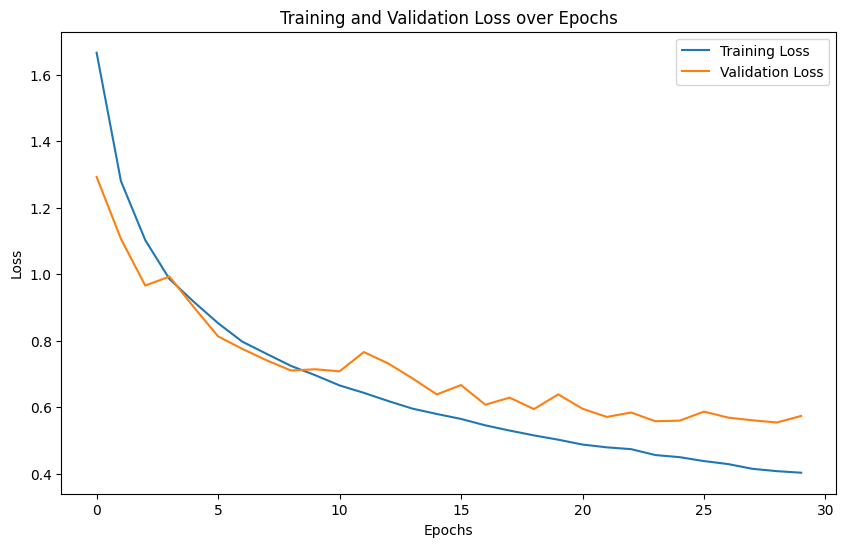

In [9]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()